In [1]:
import pandas as pd
from nltk.corpus import stopwords
from tools import *
import nltk.data
import numpy as np
from collections import Counter
import nltk
import gensim
import spacy
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore", category=DeprecationWarning)
sp = spacy.load('en_core_web_sm')
stopwords = set(stopwords.words('english'))
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [2]:
data = pd.read_csv('data/aei_token.csv')
data['word_token'] = data['word_token'].apply(lambda x: x.strip("[|]|'").split("', '"))

In [3]:
sent_transform = lambda x: [[j.strip("\'") for j in i.split("', '")] for i in x.strip('[|]').split("'], ['")]
data['sent_token'] = data['sent_token'].apply(sent_transform)

text = data['sent_token'].sum()
print('summation finished.')
words_W2V = gensim.models.word2vec.Word2Vec(text)
words_W2V.save("aei_WORD2Vec")
#words_W2V = gensim.models.word2vec.Word2Vec.load('aei_WORD2Vec')

summation finished.


In [4]:
data['reduced_tokens'] = data['word_token'].apply(lambda x:
                                                 [i for i in x if i in words_W2V])
data['len'] = data['reduced_tokens'].apply(lambda x: len(x))
data = data[data['len']!=0].copy()
data["dim"] = data['reduced_tokens'].apply(lambda x: dimension(words_W2V, x).reshape(1,-1))

In [5]:
for key in target_word:
    dim = dimension(words_W2V, target_word[key]).reshape(1,-1)
    data[key] = data['dim'].apply(lambda x: cosine_similarity(dim, x)[0][0])
    
names = list(target_word.keys())
data['topic'] = data[names].apply(lambda x: names[list(x).index(max(x))], axis=1)

In [11]:
names = list(target_word.keys())
df_distance = np.zeros([len(names),len(names)])
for i in range(len(names)):
    for j in range(len(names)):
        dim1 = dimension(words_W2V, target_word[names[i]]).reshape(1,-1)
        dim2 = dimension(words_W2V, target_word[names[j]]).reshape(1,-1)
        df_distance[i][j] = cosine_similarity(dim1, dim2)[0][0]

df_distance = pd.DataFrame(df_distance)
df_distance.columns = names
df_distance.index = names

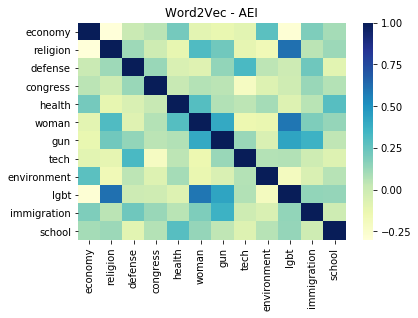

In [12]:
sns.heatmap(df_distance, cmap="YlGnBu")
plt.title('Word2Vec - AEI')
plt.show()

In [9]:
## as a way to avoid turning numbers and non-sensical words into features.
data['cleaned_text'] = data['word_token'].apply(lambda x: " ".join(x))

ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, 
                                                                 max_features=1000, min_df=3, 
                                                                 stop_words='english', 
                                                                 norm='l2')
groupsTFVects = ngTFVectorizer.fit_transform(data['cleaned_text'])
pca = PCA(n_components=2).fit_transform(groupsTFVects.toarray())
df_plot = pd.DataFrame({'year': data['Year'], 
                        'topic': data['topic'], 
                        'pca1': pca[:,0],
                        'pca2': pca[:,1]})

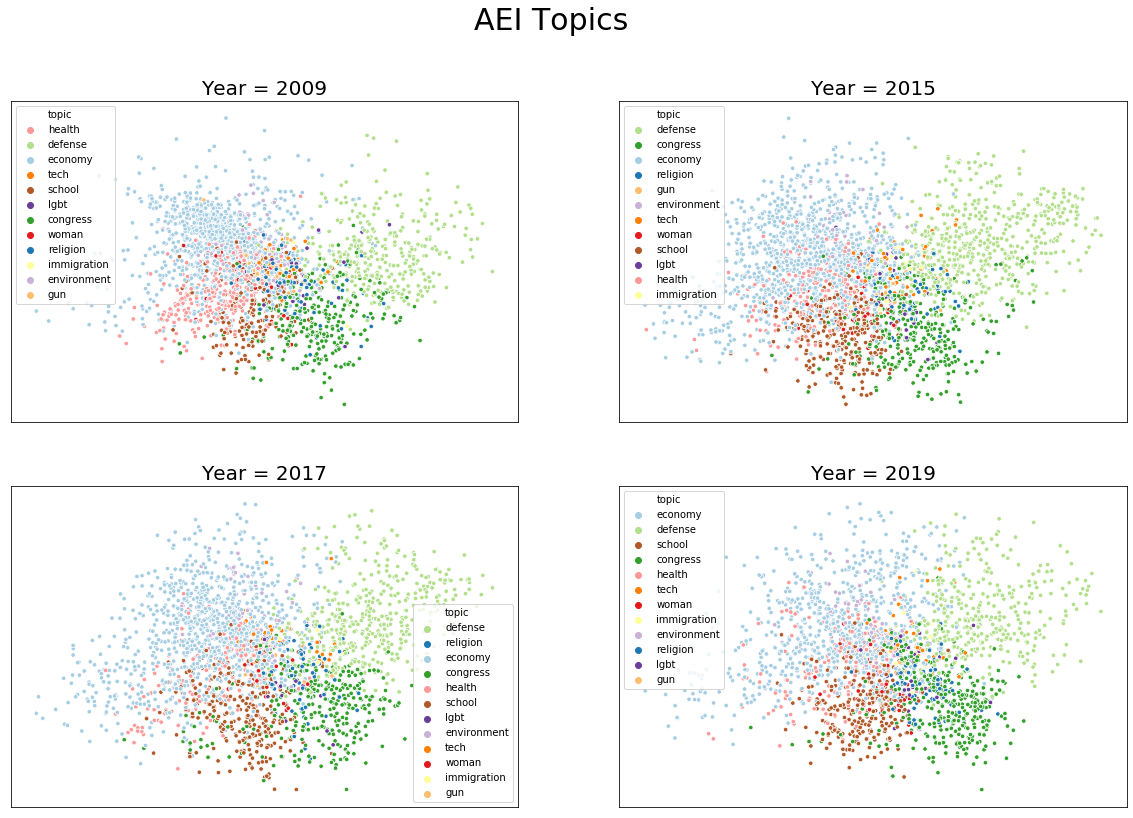

In [13]:
target_years = [2009, 2015, 2017, 2019]
fig, axes = plt.subplots(2, 2, figsize=(20, 13))
fig.suptitle('AEI Topics', fontsize=30)
plots = [plot_clusters(df_plot, x, names) for x in zip(target_years, axes.reshape(-1, 1))]